In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("Sample - Superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [5]:
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

## Forecasting Furniture

In [6]:
df_furniture = df[df['Category'] == 'Furniture']
df_furniture.shape

(2121, 21)

In [7]:
df_furniture = df_furniture[['Order Date', 'Sales']]

In [8]:
df_furniture.head()

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840


## Group the values by date and sort by date column

In [9]:
df_furniture_group = df_furniture.groupby(['Order Date']).sum()

In [10]:
df_furniture_group.reset_index(inplace = True)
df_furniture_group.sort_values(by = 'Order Date', inplace = True)

In [11]:
df_furniture_group.shape

(889, 2)

In [12]:
print('Minimum Order Date:', df_furniture_group['Order Date'].min())
print('Maximum Order Date:', df_furniture_group['Order Date'].max())

Minimum Order Date: 2014-01-06 00:00:00
Maximum Order Date: 2017-12-30 00:00:00


### There are almost 4 years of data

In [13]:
df_furniture_group.set_index('Order Date', inplace = True)
df_furniture_group.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


## We will forecast the sales for every month

In [14]:
monthly_df = df_furniture_group['Sales'].resample('MS').mean()
monthly_df.head()

Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049188
Freq: MS, Name: Sales, dtype: float64

<AxesSubplot: xlabel='Order Date'>

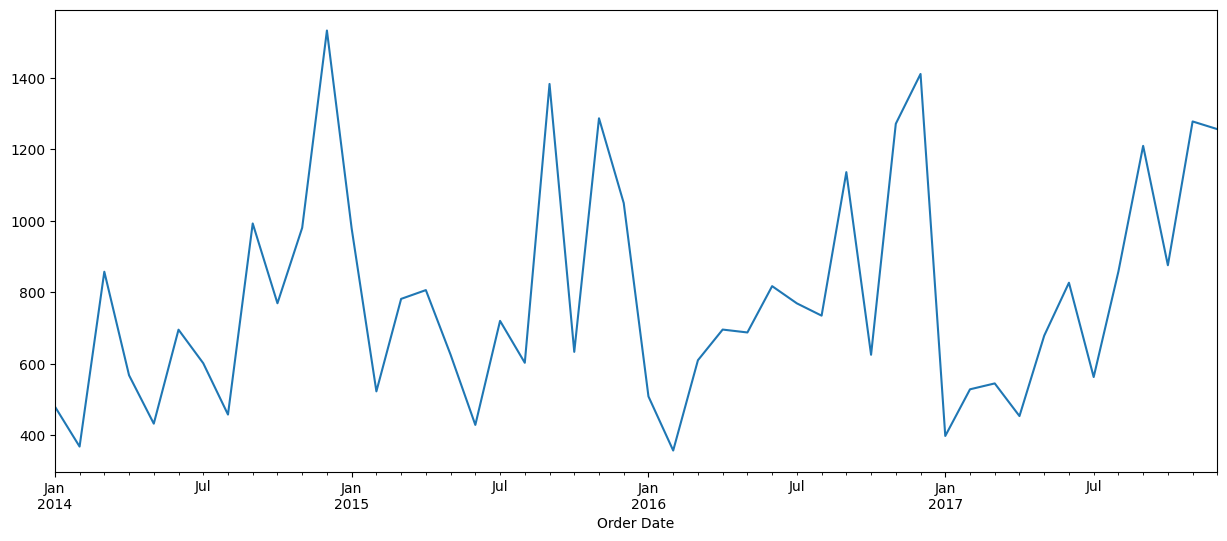

In [15]:
monthly_df.plot(kind = 'line', figsize=(15, 6))

### There exists a pattern in the data. The sales are usually low in the beginning of the month and then peaks at year end

## Seasonal Decomposition

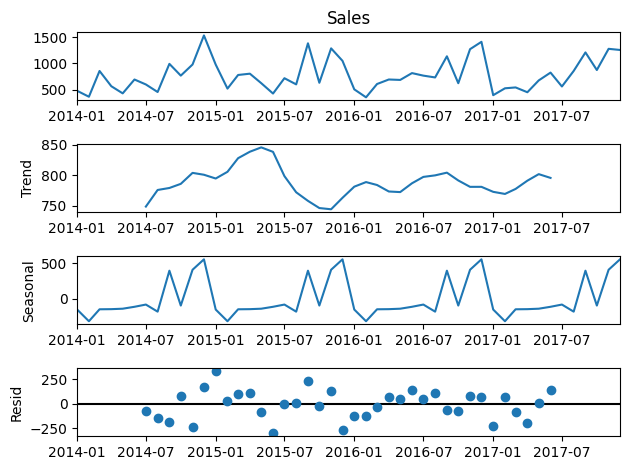

In [16]:
decomposition = sm.tsa.seasonal_decompose(monthly_df, model='additive')
decomposition.plot()
plt.show()

### From the above plot, we can clearly see a seasonality pattern (yearly) in the sales of the furniture

## Forecasting:

- Check for stationary using dickey-fuller test
- Plot ACF and PACF to identify values of p and q

## Checking Stationary

In [17]:
def check_stationarity(data):
    dftest = statsmodels.tsa.stattools.adfuller(data)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    print('p-value:', pvalue)
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
        return 0
    else:
        print('The series is NOT stationary')
        return 1
    

In [18]:
check_stationarity(monthly_df)

p-value: 9.168756655665362e-06
The series is stationary


0

### Since the data is stationary, there is no need for differencing

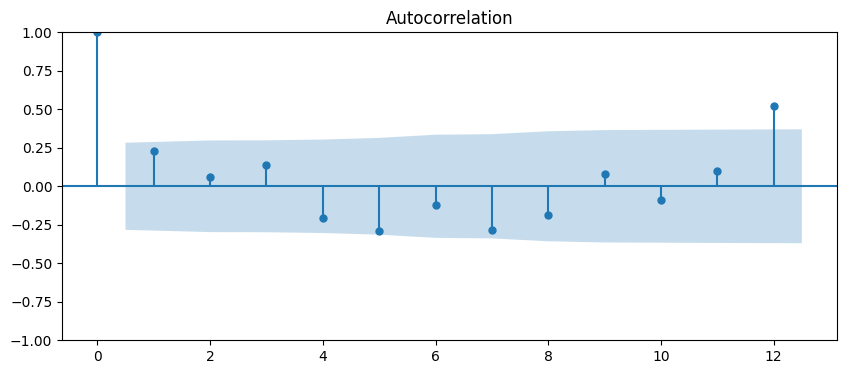

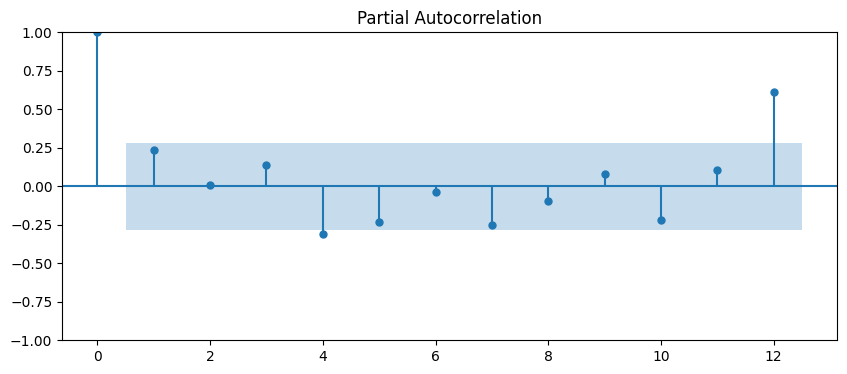

In [19]:
plt.rc('figure',figsize=(10,4))

plot_acf(monthly_df, lags=12);
plot_pacf(monthly_df, lags=12);

In [20]:
#function to calculate MAPE. 
def calculate_mape(actual, predicted):
  
    if not all([isinstance(actual, np.ndarray),isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),np.array(predicted)
  
    # Calculate the MAPE value and return
    return round(np.mean(np.abs((
      actual - predicted) / actual)) * 100, 2)

## Grid Search to identify best parameters for p and q

- Below is a function to find the best p and q paramters for ARIMA
- AIC is used as a metric to identify the best paramters 

In [21]:
def best_params_arima(series,d):
    # Define the p,and q parameters to take any value between 0 and 3
    p=d=q=range(0, 3)
    
    # Generate all different combinations of p and q 
    pdq = list(itertools.product(p,d,q))
    bestAIC = np.inf
    bestparam = None 
    for param in pdq:
        try:
            model = statsmodels.tsa.arima.model.ARIMA(series,order=param)
            results = model.fit()
            print(param,results.aic)
            
            #if current run of AIC is better than the best one so far, overwrite it
            if results.aic<bestAIC:
                bestAIC = results.aic
                bestparam = param
        except:
            continue
    return bestparam

In [22]:
monthly_df.shape

(48,)

### Since we have 4 years of data, we will use the first 3 years for traning and the last year for testing

In [23]:
# train test split (train : 36 months and test 12 months)

train = monthly_df[:36]
test = monthly_df[36:]


In [24]:
# getting the best 'd' value using adf test
d = check_stationarity(train)
# finding the best p and q values using grid search
params=best_params_arima(train,d)

p-value: 0.0004478775696409161
The series is stationary
(0, 0, 0) 517.7222238695413
(0, 0, 1) 518.1753682175204
(0, 0, 2) 520.1084257793148
(0, 1, 0) 515.4250585881592
(0, 1, 1) 506.5509556116426
(0, 1, 2) 507.9326057965348
(0, 2, 0) 537.7882950480113
(0, 2, 1) 506.81269068059333
(0, 2, 2) 499.47905859831315
(1, 0, 0) 518.0115261545806
(1, 0, 1) 519.8613523217305
(1, 0, 2) 520.8254868274737
(1, 1, 0) 509.74426652284166
(1, 1, 1) 507.71275561924455
(1, 1, 2) 509.36129863416716
(1, 2, 0) 519.9083900143071
(1, 2, 1) 501.72766106266477
(1, 2, 2) 501.39330382424976
(2, 0, 0) 519.8917355038269
(2, 0, 1) 521.8561133230204
(2, 0, 2) 521.4542891159576
(2, 1, 0) 508.8656308903868
(2, 1, 1) 510.8628944763396
(2, 1, 2) 510.9067514634299
(2, 2, 0) 510.46547739731216
(2, 2, 1) 501.30381706016954
(2, 2, 2) 503.30041763120045


In [25]:
print('Best parameters of ARIMA Model:')
print(params)

Best parameters of ARIMA Model:
(0, 2, 2)


In [26]:
# model fitting and predictions
arima = statsmodels.tsa.arima.model.ARIMA(train,order=params).fit()
preds_arima = arima.predict(start=train.shape[0],end=monthly_df.shape[0]-1)
preds_arima = abs(preds_arima)

#storing the results in a dataframe
results = preds_arima.to_frame()

#calculating mape and r2 and storing it in 2 dictionaries
error = calculate_mape(test,preds_arima)

#storing the best params
params_arima = params 


In [27]:
results

,predicted_mean
2017-01-01,1188.307766
2017-02-01,1207.817680
2017-03-01,1227.327594
2017-04-01,1246.837508
2017-05-01,1266.347421
2017-06-01,1285.857335
2017-07-01,1305.367249
2017-08-01,1324.877163
2017-09-01,1344.387076
2017-10-01,1363.896990


In [28]:
print('MAPE value of ARIMA Model: ', error)

MAPE value of ARIMA Model:  86.97


In [29]:
#Creating dataframe to store train and test MAPE
test_log = pd.DataFrame(columns = ['Model', 'Train MAPE', 'Test MAPE'])

In [30]:
preds_arima = arima.predict(start=0,end=monthly_df.shape[0]-12-1)
preds_arima = abs(preds_arima)
error_train = calculate_mape(train,preds_arima)


arima_df ={'Model': 'ARIMA', 'Train MAPE': error_train, 'Test MAPE' : error}
test_log = test_log.append(arima_df, ignore_index = True)
test_log

,Model,Train MAPE,Test MAPE
0,ARIMA,41.7,86.97


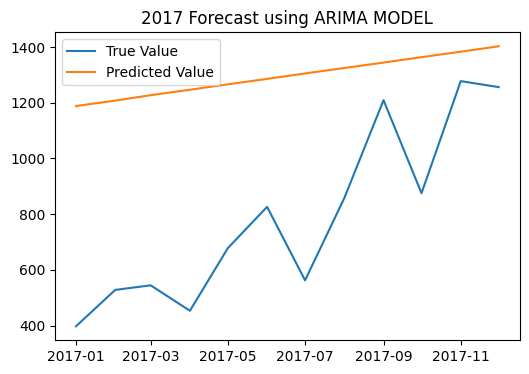

In [31]:
fig, axs = plt.subplots(1,figsize=(6,4),sharex=True)
axs.set_title("2017 Forecast using ARIMA MODEL")
axs.plot(test, label = 'True Value')
axs.plot(results['predicted_mean'], label = 'Predicted Value')
plt.legend()

### From the above predictions, we see that the ARIMA does not capture the seasonality, so we will try SARIMAX

# SARIMAX

- Below is a function to identify the best parameters for SARIMA.
- SARIMA uses seasonal paramters in addition to (p,d,q) and also uses the seasonality. 
- We are using yearly seasonality 



In [32]:
def sarima_params(series,d):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    bestAIC = np.inf
    bestParam = None
    bestSParam = None
    
    print('Running GridSearch')
    
    #use gridsearch to look for optimial sarima parameters
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(series,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                
                #if current run of AIC is better than the best one so far, overwrite it
                if results.aic<bestAIC:
                    bestAIC = results.aic
                    bestParam = param
                    bestSParam = param_seasonal

            except:
                continue
    return bestParam, bestSParam

In [33]:
# getting the best 'd' value using adf test
d = check_stationarity(train)
# finding the best p and q values using grid search
params,sparams = sarima_params(train,d)


p-value: 0.0004478775696409161
The series is stationary
Running GridSearch
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93444D+00    |proj g|=  2.22624D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   4.427D-07   7.934D+00
  F =   7.9343563167322380     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.02223D+00    |proj g|=  3.75911D-03

At iterate   15    f=  2.01724D+00    |proj g|=  5.83538D-02

At iterate   20    f=  1.96841D+00    |proj g|=  2.86805D-02

At iterate   25    f=  1.95105D+00    |proj g|=  1.24221D-02

At iterate   30    f=  1.95039D+00    |proj g|=  1.41518D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     40      1     0     0   1.216D-06   1.950D+00
  F =   1.9503884404980165     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.89395D+00    |proj g|=  7.17943D-01

At iterate   20    f=  4.64689D+00    |proj g|=  2.02764D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     37      1     0     0   4.052D-06   4.647D+00
  F =   4.6466291087421432     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.89595D+00    |proj g|=  3.74135D-01

At iterate    5    f=  4.71718D+00    |proj g|=  2.99215D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.75612D+00    |proj g|=  1.56115D-02

At iterate   35    f=  1.75603D+00    |proj g|=  4.76719D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     43      1     0     0   4.767D-06   1.756D+00
  F =   1.7560319788758862     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94033D+00    |proj g|=  1.44783D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.88216D+00    |proj g|=  6.65893D-02

At iterate   20    f=  1.79810D+00    |proj g|=  2.15256D-02

At iterate   25    f=  1.79059D+00    |proj g|=  3.47400D-02

At iterate   30    f=  1.78604D+00    |proj g|=  7.70073D-04

At iterate   35    f=  1.78604D+00    |proj g|=  5.38725D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     50      1     0     0   5.387D-07   1.786D+00
  F =   1.7860352371474957     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.63389D+00    |proj g|=  9.89947D-02

At iterate   25    f=  1.61613D+00    |proj g|=  3.75047D-03

At iterate   30    f=  1.61598D+00    |proj g|=  6.22023D-05

At iterate   35    f=  1.61598D+00    |proj g|=  6.85371D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37     43      1     0     0   5.828D-06   1.616D+00
  F =   1.6159757496109204     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.05742D+00    |proj g|=  6.45200D-02

At iterate   15    f=  1.96593D+00    |proj g|=  2.42474D-02

At iterate   20    f=  1.96128D+00    |proj g|=  1.19387D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   1.194D-05   1.961D+00
  F =   1.9612820469548420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74107D+00    |proj g|=  1.82008D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.69845D+00    |proj g|=  2.72997D-01

At iterate    5    f=  4.61890D+00    |proj g|=  5.60291D-04

At iterate   10    f=  4.61664D+00    |proj g|=  3.88452D-02

At iterate   15    f=  4.58358D+00    |proj g|=  2.78458D-02

At iterate   20    f=  4.58035D+00    |proj g|=  3.76519D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     27      1     0     0   4.007D-06   4.580D+00
  F =   4.5803453764226996     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  4.33801D+00    |proj g|=  4.99034D-03

At iterate   30    f=  4.33768D+00    |proj g|=  3.69103D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     54      1     0     0   3.691D-05   4.338D+00
  F =   4.3376838358516840     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01095D+00    |proj g|=  4.51278D-02

At iterate    5    f=  2.00094D+00    |proj g|=  1.27481D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.91207D+00    |proj g|=  5.77799D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     41      1     0     0   1.024D-05   1.912D+00
  F =   1.9120651871847723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79346D+00    |proj g|=  8.32219D-02

At iterate    5    f=  6.77580D+00    |proj g|=  1.53751D+00

At iterate   10    f=  6.77266D+00    |proj g|=  2.73693D-03

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.83717D+00    |proj g|=  1.67304D-03

At iterate   15    f=  1.82304D+00    |proj g|=  5.42334D-02

At iterate   20    f=  1.71924D+00    |proj g|=  4.45252D-02

At iterate   25    f=  1.71860D+00    |proj g|=  1.70137D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   8.386D-06   1.719D+00
  F =   1.7186029049354283     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.26622D+00    |proj g|=  1.62646D-02

At iterate   15    f=  4.26611D+00    |proj g|=  3.11928D-03

At iterate   20    f=  4.26490D+00    |proj g|=  3.89210D-02

At iterate   25    f=  4.22777D+00    |proj g|=  3.48435D-01

At iterate   30    f=  4.18740D+00    |proj g|=  4.54606D-03

At iterate   35    f=  4.18683D+00    |proj g|=  8.18705D-03

At iterate   40    f=  4.18665D+00    |proj g|=  8.37613D-03

At iterate   45    f=  4.18659D+00    |proj g|=  2.27973D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     55      1     0     0   1.994D-04   4.187D+00
  F =   4.18659371099

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   30    f=  1.75072D+00    |proj g|=  6.77521D-03

At iterate   35    f=  1.75060D+00    |proj g|=  3.84896D-04

At iterate   40    f=  1.75060D+00    |proj g|=  3.01388D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     44      1     0     0   3.014D-06   1.751D+00
  F =   1.7505977591016260     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83367D+00    |proj g|=  5.90168D-06

        

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29144D+00    |proj g|=  3.31115D-02

At iterate    5    f=  4.29043D+00    |proj g|=  2.30707D-03

At iterate   10    f=  4.28868D+00    |proj g|=  3.89780D-02

At iterate   15    f=  4.25035D+00    |proj g|=  1.50539D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   3.320D-06   4.250D+00
  F =   4.2501053199914809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.86930D+00    |proj g|=  2.95817D-03

At iterate   15    f=  1.86514D+00    |proj g|=  3.86138D-02

At iterate   20    f=  1.79209D+00    |proj g|=  2.28310D-02

At iterate   25    f=  1.79115D+00    |proj g|=  8.63359D-04

At iterate   30    f=  1.79072D+00    |proj g|=  1.07071D-02

At iterate   35    f=  1.78988D+00    |proj g|=  8.44140D-03

At iterate   40    f=  1.78905D+00    |proj g|=  2.50992D-03

At iterate   45    f=  1.78865D+00    |proj g|=  8.83426D-03

At iterate   50    f=  1.78824D+00    |proj g|=  3.62601D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     70   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  6.57378D+00    |proj g|=  9.34736D-02

At iterate   10    f=  6.56915D+00    |proj g|=  4.10384D-04

At iterate   15    f=  6.56914D+00    |proj g|=  4.22266D-03

At iterate   20    f=  6.56741D+00    |proj g|=  4.24520D-02

At iterate   25    f=  6.56319D+00    |proj g|=  3.94954D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     33      1     0     0   4.321D-06   6.563D+00
  F =   6.5631874496180451     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.19667D+00    |proj g|=  3.40792D-01

At iterate    5    f=  4.07972D+00    |proj g|=  1.26883D-02

At iterate   10    f=  4.07953D+00    |proj g|=  8.98434D-04

At iterate   15    f=  4.07135D+00    |proj g|=  5.50586D-02

At iterate   20    f=  3.99966D+00    |proj g|=  5.37815D-02

At iterate   25    f=  3.99627D+00    |proj g|=  7.80745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     31      1     0     0   5.363D-05   3.996D+00
  F =   3.9961942552593674     

CONVERGENCE: REL_RED

 This problem is unconstrained.



At iterate   25    f=  1.62963D+00    |proj g|=  6.64707D-02

At iterate   30    f=  1.61089D+00    |proj g|=  1.71226D-02

At iterate   35    f=  1.60813D+00    |proj g|=  5.66494D-03

At iterate   40    f=  1.60741D+00    |proj g|=  3.23691D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     52      1     0     0   3.759D-06   1.607D+00
  F =   1.6074080618204492     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [34]:
print('Best parameters of SARIMAX Model:')
print(params,sparams)

Best parameters of SARIMAX Model:
(1, 1, 1) (0, 1, 1, 12)


In [35]:
# model fitting and predictions
sarima= sm.tsa.statespace.SARIMAX(train,order=params,seasonal_order=sparams).fit()
preds_sarima = sarima.predict(start=train.shape[0],end=monthly_df.shape[0]-1)
print('AIC of best model: ',sarima.aic)
preds_sarima = abs(preds_sarima)

#storing the results in a dataframe
results = preds_sarima.to_frame()

#calculating mape and r2 and storing it in 2 dictionaries
error = calculate_mape(test,preds_sarima)

#storing the best params
params_sarima = params 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.54310D+00    |proj g|=  2.33420D-01

At iterate    5    f=  4.47142D+00    |proj g|=  2.88942D-02

At iterate   10    f=  4.46244D+00    |proj g|=  3.05907D-03

At iterate   15    f=  4.46192D+00    |proj g|=  4.16351D-03


 This problem is unconstrained.



At iterate   20    f=  4.43026D+00    |proj g|=  8.38953D-02

At iterate   25    f=  4.39794D+00    |proj g|=  6.37620D-03

At iterate   30    f=  4.39591D+00    |proj g|=  4.30662D-04

At iterate   35    f=  4.39575D+00    |proj g|=  3.54352D-04

At iterate   40    f=  4.39573D+00    |proj g|=  1.40000D-05

At iterate   45    f=  4.39573D+00    |proj g|=  6.85753D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     56      1     0     0   6.858D-05   4.396D+00
  F =   4.3957252363848704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
AIC of best model:  324.49221701971067


In [36]:
results

,predicted_mean
2017-01-01,766.679225
2017-02-01,515.207179
2017-03-01,838.735196
2017-04-01,780.004486
2017-05-01,673.691376
2017-06-01,737.841262
2017-07-01,787.111256
2017-08-01,692.948294
2017-09-01,1254.436103
2017-10-01,771.604715


In [37]:
print('MAPE value of SARIMA Model: ', error)

MAPE value of SARIMA Model:  26.64


In [38]:
preds_sarima = sarima.predict(start=0,end=monthly_df.shape[0]-12-1)
preds_sarima = abs(preds_sarima)
error_train = calculate_mape(train,preds_sarima)


sarima_df ={'Model': 'SARIMA', 'Train MAPE': error_train, 'Test MAPE' : error}
test_log = test_log.append(sarima_df, ignore_index = True)
test_log

,Model,Train MAPE,Test MAPE
0,ARIMA,41.70,86.97
1,SARIMA,33.92,26.64


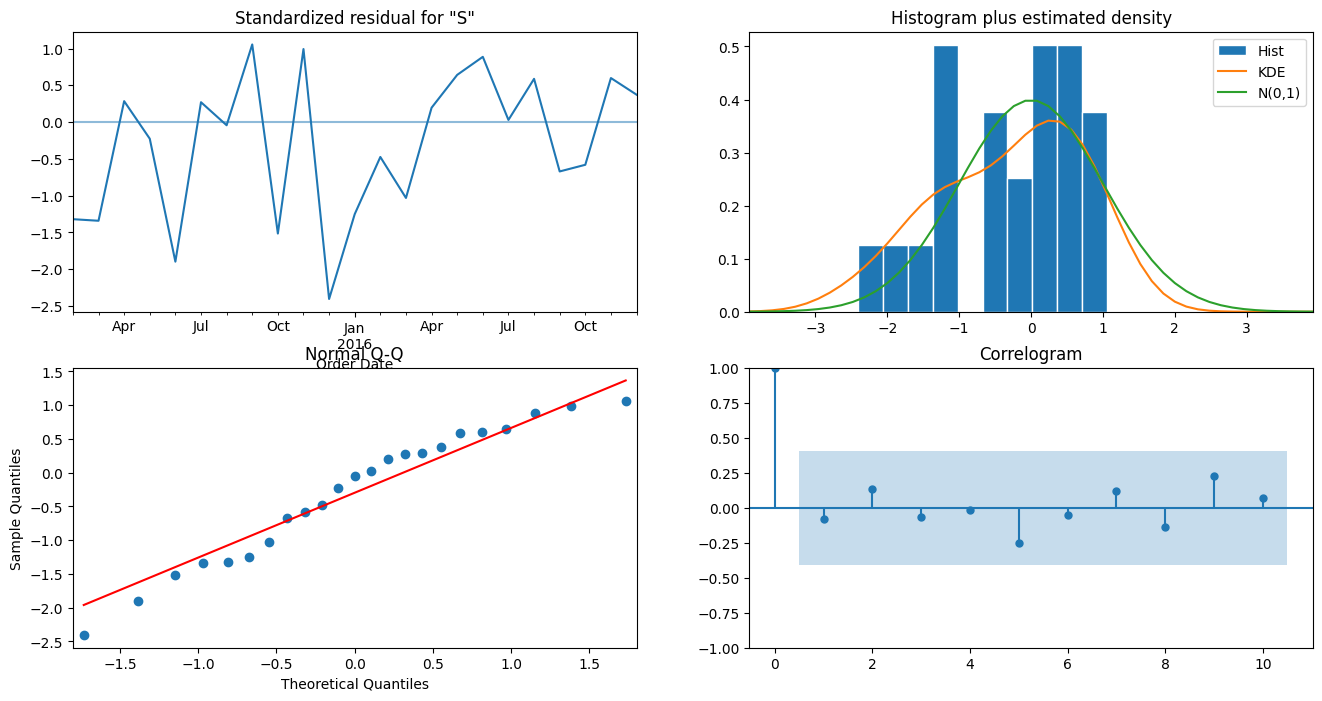

In [39]:
sarima.plot_diagnostics(figsize=(16, 8))
plt.show()

### From the above Q-Q plot (bottom left), we see that SARIMA model residuals are uncorrelated and are almost close to normally distributed with zero-mean

### Also, from the top right autocorrelation plot, we see that the residuals over time does not display any obvious seasonality and appear to be white noise.

### So we can conclude, our model performs satisfactorily good.

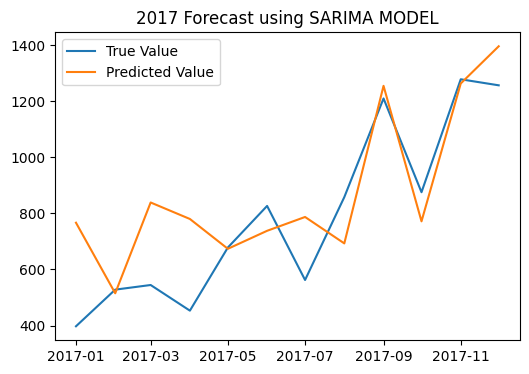

In [40]:
fig, axs = plt.subplots(1,figsize=(6,4),sharex=True)
axs.set_title("2017 Forecast using SARIMA MODEL")
axs.plot(test, label = 'True Value')
axs.plot(results['predicted_mean'], label = 'Predicted Value')
plt.legend()

### From the MAPE score and the forecast value, we see that SARIMAX has done a good job in capturing the trend and seasonality

## Confidence interval for future years

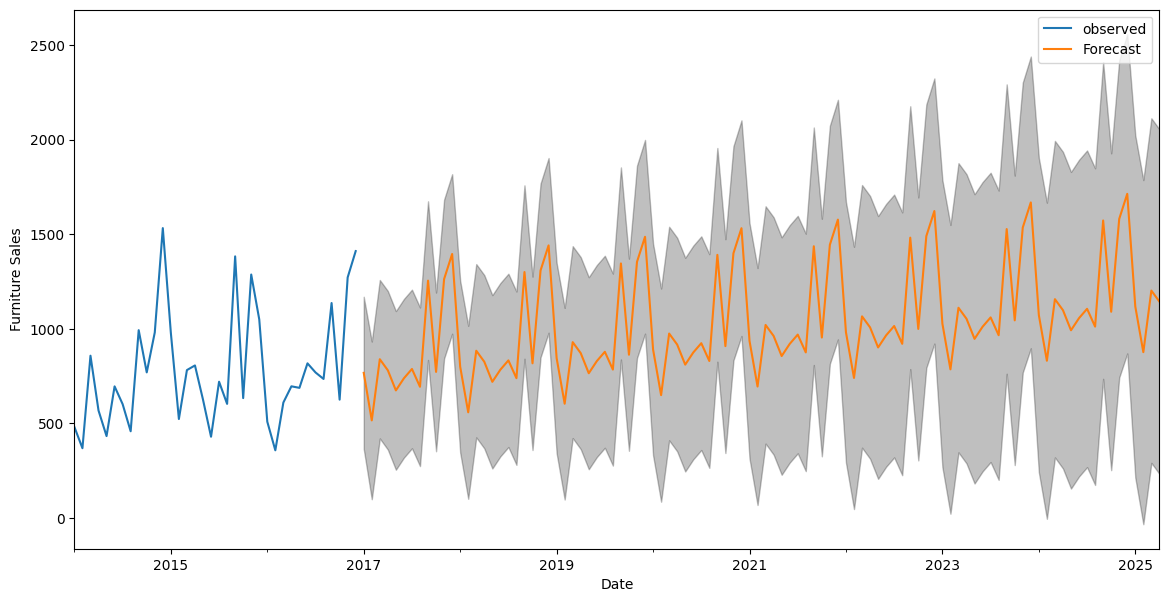

In [41]:
pred_uc = sarima.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = train.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### The confidence band increases as we progress over time i.e our model becomes less confident as it predicts future values

# Prophet Model

### Prophet allows to deal with multiple seasonalities. We will apply Pophet to our data and see if there is any improvement in our prediction

!pip install fbprophet

In [42]:
from fbprophet import Prophet

In [43]:
# setting the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)

### Prophet requires 2 columns with names as ds and y. Modifying the dataframe accordingly

In [44]:
train_prophet = pd.DataFrame(train)

In [45]:
train_prophet.reset_index(inplace=True)

In [46]:
train_prophet = train_prophet.rename(columns = {'Order Date': 'ds', 'Sales': 'y'})

In [47]:
train_prophet.head()

,ds,y
0,2014-01-01,480.194231
1,2014-02-01,367.931600
2,2014-03-01,857.291529
3,2014-04-01,567.488357
4,2014-05-01,432.049188


In [48]:
my_model.fit(train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -48.3367


Iteration  1. Log joint probability =    23.5646. Improved by 71.9012.
Iteration  2. Log joint probability =    40.4718. Improved by 16.9072.
Iteration  3. Log joint probability =    57.8151. Improved by 17.3433.
Iteration  4. Log joint probability =    57.8512. Improved by 0.0361601.
Iteration  5. Log joint probability =    57.9189. Improved by 0.0676931.
Iteration  6. Log joint probability =    57.9563. Improved by 0.0373491.
Iteration  7. Log joint probability =     57.975. Improved by 0.0186725.
Iteration  8. Log joint probability =    58.0167. Improved by 0.0417545.
Iteration  9. Log joint probability =    58.0185. Improved by 0.00180699.
Iteration 10. Log joint probability =     58.081. Improved by 0.062485.
Iteration 11. Log joint probability =    58.0867. Improved by 0.0056813.
Iteration 12. Log joint probability =    58.1672. Improved by 0.080488.
Iteration 13. Log joint probability =     64.376. Improved by 6.20879.
Iteration 14. Log joint probability =    64.4146. Improved b

In [49]:
future_dates = my_model.make_future_dataframe(periods=12, freq='MS')
future_dates.tail()

,ds
43,2017-08-01
44,2017-09-01
45,2017-10-01
46,2017-11-01
47,2017-12-01


In [50]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
43,2017-08-01,714.448421,486.357273,928.116514
44,2017-09-01,1208.615981,980.316628,1454.634709
45,2017-10-01,747.521869,522.949215,971.385560
46,2017-11-01,1271.011087,1052.254723,1493.023069
47,2017-12-01,1473.348777,1254.481520,1709.374867


#### Definition of variables in the dataframe:

- ds contains the timestamp
- yhat contains the forecasted value of the time series
- yhat_lower and yhat_upper contains the lower and upper bound of the confidence interval for the forecast

Text(0.5, 1.0, 'Actual and Forescasted Values using Prophet')

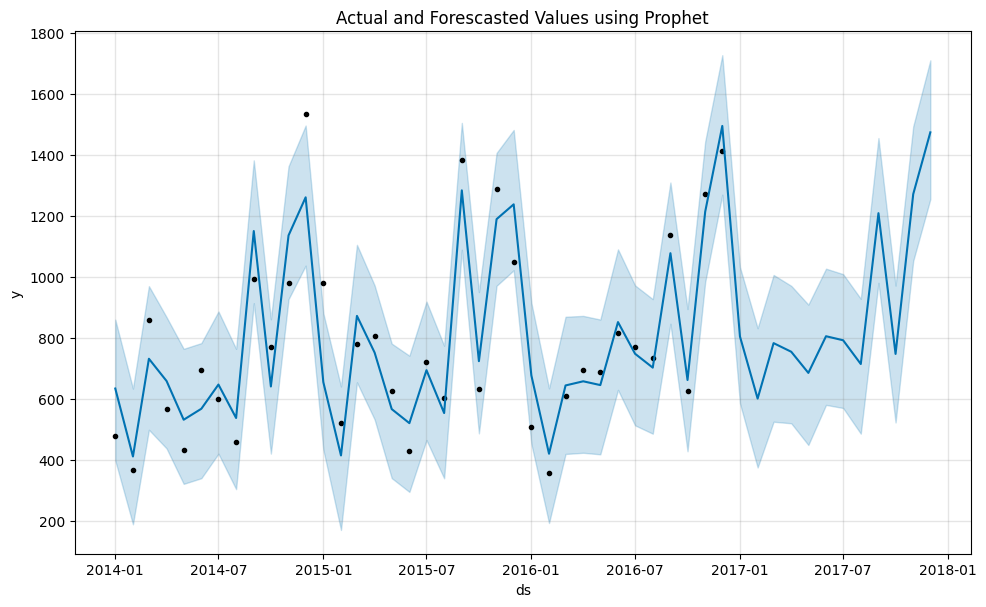

In [51]:
# plot
fig = my_model.plot(forecast)
plt.title('Actual and Forescasted Values using Prophet')

In [52]:
result_prophet = forecast[['ds','yhat']].tail(12)

In [53]:
result_prophet.set_index('ds', inplace = True)

In [54]:
train_prophet = forecast[['ds','yhat']].head(48)
train_prophet.set_index('ds', inplace = True)
train_prophet.head(5)

,yhat
ds,
2014-01-01,634.139381
2014-02-01,411.560088
2014-03-01,731.724706
2014-04-01,658.775745
2014-05-01,531.946837


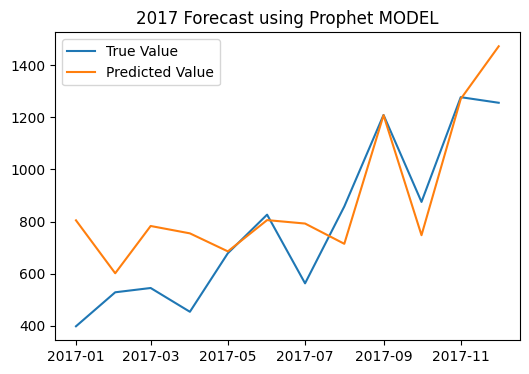

In [55]:
fig, axs = plt.subplots(1,figsize=(6,4),sharex=True)
axs.set_title("2017 Forecast using Prophet MODEL")
axs.plot(test, label = 'True Value')
axs.plot(result_prophet, label = 'Predicted Value')
plt.legend()

### The prediction of the model is very similar to that of SARIMAX (except for the initial few years in which SARIMAX does well than Prophet), we will calculate MAPE and see if there are any idfferencd

In [56]:
error_train = calculate_mape(train,result_prophet)
error_test = calculate_mape(test,result_prophet)


sarima_df ={'Model': 'Prophet', 'Train MAPE': error_train, 'Test MAPE' : error_test}
test_log = test_log.append(sarima_df, ignore_index = True)
test_log

,Model,Train MAPE,Test MAPE
0,ARIMA,41.70,86.97
1,SARIMA,33.92,26.64
2,Prophet,48.54,50.52


### From the above table we see that MAPE score of both train and test data using SARIMA model is the least and hence we will use that as our final model

### References:

- https://towardsdatascience.com/an-overview-of-time-series-forecasting-models-a2fa7a358fcb
- https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3
- https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
- https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a